# Presentation

In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage.morphology import skeletonize as skel 
from skimage.morphology import disk
from scipy import interpolate
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import imageio as iio
import scipy.ndimage as ndi

# Loading image and setting formats

In [40]:
#Loading image and setting proper format

im = iio.imread('2fil.PNG')
im = color.rgb2gray(im) 

multi = iio.imread('multifil.PNG')
multi = color.rgb2gray(multi)
def im_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

dx5 = iio.imread('Dx5-2 20nM 100%labelled wBSA_Thu Apr 11 2019_15.54.14.tif')
dx5 = color.rgb2gray(dx5)
#im_show(im)
#im_show(multi)
#im_show(dx5)

# Normalizing images 

https://www.researchgate.net/post/How_do_I_normalize_2_grayscale_images_so_that_they_are_equivalent_to_each_other

# Thresholding

In [41]:
#Experimenting to get a better final image
#idea that the interface could have slidebars to adjust image processing
def pre_processing_dark(multi):    
    #thresholding, masking, filtering
    masked_multi = np.where(multi < np.percentile(multi, 99),0 , multi)
    mask_dilate = ndi.binary_dilation(masked_multi, iterations=1)
    mask_erosion = ndi.binary_erosion(mask_dilate, iterations=2)
    mask_closed = ndi.binary_closing(mask_erosion, iterations=3)
    mask_median = filters.median(mask_closed, disk(2.5))
    multi_final = mask_median
    
    return multi_final

def pre_processing_bright(multi):    
    #thresholding, masking, filtering
    masked_multi = np.where(multi < np.percentile(multi, 94),0 , multi)
    mask_dilate = ndi.binary_dilation(masked_multi, iterations=3)
    mask_erosion = ndi.binary_erosion(mask_dilate, iterations=2)
    mask_closed = ndi.binary_closing(mask_erosion, iterations=2)
    mask_median = filters.median(mask_closed, disk(1.5))
    multi_final = mask_median
    
    return multi_final

multi_final = pre_processing_dark(multi)
#im_show(multi_final)

# Labels and boxes

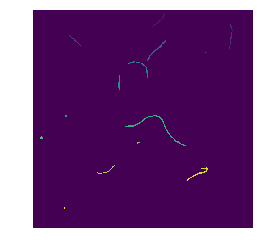

In [42]:
#to see how labels work
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html
labels, nobjects = ndi.label(multi_final)
nobjects
boxes = ndi.find_objects(labels)
plt.imshow(labels)
plt.axis('off')
plt.show()

# Getting rid of small parts

In [43]:
objects = [np.array(multi_final[boxes[i]]) for i in range(0,nobjects-1) if (np.array(multi_final[boxes[i]]).shape[0]*np.array(multi_final[boxes[i]]).shape[1] > 600)]
#for i in objects:
    #im_show(i)

# Singlifying each object

In [44]:
def singlify(list_of_objects):
    for single_object in list_of_objects:
        #first part is to get labels and boxes on each single object
        labels, nobs = ndi.label(single_object)
        boxes = ndi.find_objects(labels)

        #if there is only one object then no need to modify the picture
        if nobs>1: #if we have two or more objects 
            #Then we have to compare their size and get the index of the biggest one
            obs = [np.array(single_object[boxes[i]]) for i in range(0,nobs)]
            obs_sizes = [ob.shape[0]*ob.shape[1] for ob in obs]
            n = int(np.where(obs_sizes == np.max(obs_sizes))[0])

            #now follows the mask that will filter everything but the biggest
    
            for i in range(0,nobs):
                if i != n:
                    single_object[boxes[i]].fill(0)
    return list_of_objects 
singles =  singlify(objects)
#for i in singles:
    #im_show(i)

# Getting backbone
Using only one image for test

In [7]:
test_object = np.where(singles[5] >0, 1, 0)
test_output = skel(test_object)
#im_show(skel(test_object))

## Getting all backbones

In [45]:
def backbone(objects):
    binaries = [np.where(ob > 0, 1, 0) for ob in objects]
    backbones = [skel(binary) for binary in binaries]
    binary_backbones = [np.where(ob ==True, 1, 0) for ob in backbones]
    return binary_backbones
backbones = backbone(singles)

# From output image to output coordinates

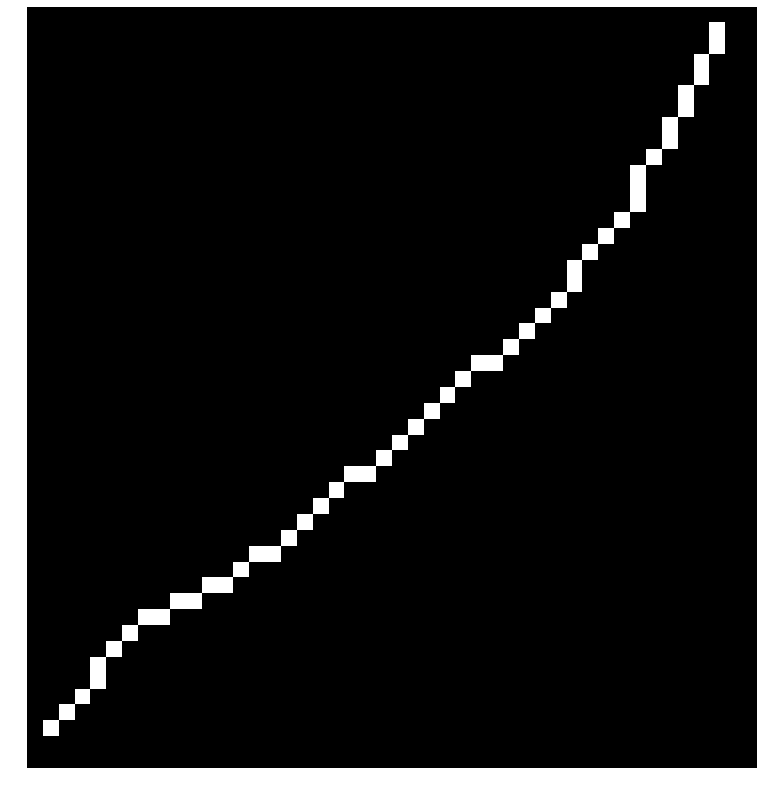

In [90]:
#the idea is to get first an arrays like [(x1,y1), (x2, y2), ...]
track = 0
locations = np.where(backbones[track]==True)
im_show(backbones[track])
coords = [[locations[0][i], float(locations[1][i])] for i in range(0, len(locations[0]))]
#this actually outputs something like (yi, xi) and with y from bigger to smaller
# ordering the output
ordered = sorted(coords, key=lambda k: [k[1], k[0]])
ordered = [np.flip(x) for x in ordered]
coords = ordered

# Fitting

## Polyfit

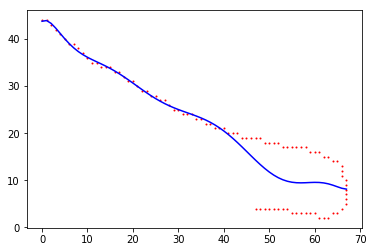

In [87]:
#trying polynomial fit up to 10th degree
x = [coords[i][0] for i in range(0, len(coords))]
y = [coords[i][1] for i in range(0, len(coords))]

#poly coeffs
z = np.polyfit(x,y,10)
#poly function
p = np.poly1d(z)
plt.plot(x,y,'ro', x, p(x), 'b', markersize=1)

## Splines interpolation

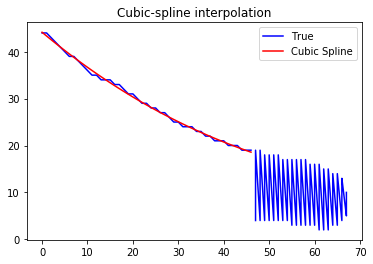

In [88]:
#to make it easier to handle we will divide our data into smaller chunks
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

n_chunks = 2
x_chunks = chunkIt(x, n_chunks)
y_chunks = chunkIt(y, n_chunks)
yfinal = []
#cubic-spline for first chunk
#plt.figure()
for i in range(0,n_chunks):
    tck = interpolate.splrep(x_chunks[i], y_chunks[i], s=13)
    ynew = interpolate.splev(x_chunks[i], tck, der=0)
    plt.plot(x_chunks[i], y_chunks[i],'b', x_chunks[i], ynew, 'r')
    yfinal.extend(ynew)
plt.legend(['True', 'Cubic Spline'])
plt.title('Cubic-spline interpolation')
plt.show()

#updating output coords
for i in range(0, len(coords)):
    coords[i].astype(float)
    coords[i][1] = yfinal[i]

# Matching JFilament's output

In [20]:
#now to match JFils format

#snake file
s = open("snake1.txt", "w+")
s.write("#\rX\rX\rX\rX\rX\rX\rX\rX\rX\r0\r")
for i in range(0, len(coords)):
    s.write("1\t"+ str(i) + "\t" + "%5.2f \t" % (coords[i][0]) + "%5.3f \t" % float((coords[i][1])) + "0\r")
s.close()

#empty elongation file, necessary to run Matlab script
e = open("elongation1.txt", "w+")
e.write("#\r#\r#\r#\r#\r#\r#\r#\r#\r\r\r#Snake Data\r#\r1 0")
e.close()